<a href="https://colab.research.google.com/github/artjow/-AI-/blob/main/ART/stylegan_nada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to StyleGAN-NADA: Zero-shot Non-Adversarial Domain Adaptation of GANs.

# Step 1: Setup required libraries and models. 
This may take a few minutes.

You may optionally enable downloads with pydrive in order to authenticate and avoid drive download limits when fetching pre-trained ReStyle and StyleGAN2 models.

In [ ]:
#@title Setup
%tensorflow_version 1.x

import os

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

pretrained_model_dir = os.path.join("/content", "models")
os.makedirs(pretrained_model_dir, exist_ok=True)

restyle_dir = os.path.join("/content", "restyle")
stylegan_ada_dir = os.path.join("/content", "stylegan_ada")
stylegan_nada_dir = os.path.join("/content", "stylegan_nada")

output_dir = os.path.join("/content", "output")

output_model_dir = os.path.join(output_dir, "models")
output_image_dir = os.path.join(output_dir, "images")

download_with_pydrive = True #@param {type:"boolean"}    
    
class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()
        
    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)
    
    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

# install requirements
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html 

!git clone https://github.com/yuval-alaluf/restyle-encoder.git $restyle_dir

downloader.download_file("1sw6I2lRIB0MpuJkpc8F5BJiSZrc0hjfE", os.path.join(pretrained_model_dir, "restyle_psp_ffhq_encode.pt"))
downloader.download_file("1e2oXVeBPXMQoUoC_4TNwAWpOPpSEhE_e", os.path.join(pretrained_model_dir, "restyle_e4e_ffhq_encode.pt"))

!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

!pip install ftfy regex tqdm 
!pip install git+https://github.com/openai/CLIP.git

!git clone https://github.com/NVlabs/stylegan2-ada/ $stylegan_ada_dir
!git clone https://github.com/rinongal/stylegan-nada.git $stylegan_nada_dir

from argparse import Namespace

import sys
import numpy as np

from PIL import Image

import torch
import torchvision.transforms as transforms

sys.path.append(restyle_dir)
sys.path.append(stylegan_nada_dir)
sys.path.append(os.path.join(stylegan_nada_dir, "ZSSGAN"))

from restyle.utils.common import tensor2im
from restyle.models.psp import pSp
from restyle.models.e4e import e4e

device = 'cuda'

%load_ext autoreload
%autoreload 2

TensorFlow 1.x selected.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1MB 1.3MB/s eta 0:04:12tcmalloc: large alloc 1147494400 bytes == 0x558e06fce000 @  0x7f0baca75615 0x558dce79ecdc 0x558dce87e52a 0x558dce7a1afd 0x558dce892fed 0x558dce815988 0x558dce8104ae 0x558dce7a33ea 0x558dce8157f0 0x558dce8104ae 0x558dce7a33ea 0x558dce81232a 0x558dce893e36 0x558dce811853 0x558dce893e36 0x558dce811853 0x558dce893e36 0x558dce811853 0x558dce893e36 0x558dce9163e1 0x558dce8766a9 0x558dce7e1cc4 0x558dce7a2559 0x558dce8164f8 0x558dce7a330a 0x558dce8113b5 0x558dce8107ad 0x558dce7a33ea 0x558dce8113b5 0x558dce7a330a 0x558dce8113b5
     |█████████████████████████████▏  | 1055.7MB 1.3MB/s eta 0:01:19tcmalloc: large alloc 1434370048 bytes == 0x558e4b624000 @  0x7f0baca75615 0x558dce79ecdc 0x558dce87e52a 0x558dce7a1afd 0x558dce892fed 0x558dce815988 0x558dce8104ae 0x558dce7a33ea 0x558dce8157f0 0x558dce8104ae 0x558dce7a33ea 0x558dce81232a 0x558d

# Step 2: Choose a model type.
Model will be downloaded and converted to a pytorch compatible version.

Re-runs of the cell with the same model will re-use the previously downloaded version. Feel free to experiment and come back to previous models :)

In [ ]:
source_model_type = 'cat' #@param['ffhq', 'cat', 'dog', 'church', 'horse']

source_model_download_path = {"ffhq":   "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl",
                              "cat":    "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/afhqcat.pkl",
                              "dog":    "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/afhqdog.pkl",
                              "church": "1iDo5cUgbwsJEt2uwfgDy_iPlaT-lLZmi",
                              "car":    "1i-39ztut-VdUVUiFuUrwdsItR--HF81w",
                              "horse":  "1irwWI291DolZhnQeW-ZyNWqZBjlWyJUn"}

model_names = {"ffhq":   "ffhq.pkl",
               "cat":    "afhqcat.pkl",
               "dog":    "afhqdog.pkl",
               "church": "stylegan2-church-config-f.pkl",
               "car":    "stylegan2-car-config-f.pkl",
               "horse":  "stylegan2-horse-config-f.pkl"}

download_string = source_model_download_path[source_model_type]
file_name = model_names[source_model_type]
pt_file_name = file_name.split(".")[0] + ".pt"

dataset_sizes = {
    "ffhq":   1024,
    "cat":    512,
    "dog":    512,
    "church": 256,
    "horse":  256
}

if not os.path.isfile(os.path.join(pretrained_model_dir, file_name)):
    print("Downloading chosen model...")

    if download_string.endswith(".pkl"):
        !wget $download_string -O $pretrained_model_dir/$file_name
    else:
        downloader.download_file(download_string, os.path.join(pretrained_model_dir, file_name))
        
if not os.path.isfile(os.path.join(pretrained_model_dir, pt_file_name)):
    print("Converting sg2 model. This may take a few minutes...")
    
    tf_path = next(filter(lambda x: "tensorflow" in x, sys.path), None)
    py_path = tf_path + f":{stylegan_nada_dir}/ZSSGAN"
    convert_script = os.path.join(stylegan_nada_dir, "convert_weight.py")
    !PYTHONPATH=$py_path python $convert_script --repo $stylegan_ada_dir --gen $pretrained_model_dir/$file_name

--2021-06-28 14:33:33--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/afhqcat.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 99.84.216.37, 99.84.216.98, 99.84.216.120, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|99.84.216.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 363999413 (347M) [binary/octet-stream]
Saving to: ‘/content/models/afhqcat.pkl’

/content/models/afh 100%[===================>] 347.14M   170MB/s    in 2.0s    

2021-06-28 14:33:35 (170 MB/s) - ‘/content/models/afhqcat.pkl’ saved [363999413/363999413]

Converting sg2 model. This may take a few minutes...
Setting up TensorFlow plugin "fused_bias_act.cu": Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Compiling... Loading... Done.
tensor(0.4964, device='cuda:0')


# Step 3: Train the model.
Describe your source and target class. These describe the direction of change you're trying to apply (e.g. "photo" to "sketch", "dog" to "the joker" or "dog" to "avocado dog").

For changes that do not require drastic shape modifications, we reccomend lambda_direction = 1.0, lambda_patch = 0.0, lambda_global = 0.0.

More drastic changes may require turning on the global loss (and / or modifying the number of iterations).


As a rule of thumb:
- Style and minor domain changes ('photo' -> 'sketch') require ~200-400 iterations.
- Identity changes ('person' -> 'taylor swift') require ~150-200 iterations.
- Simple in-domain changes ('face' -> 'smiling face') may require as few as 50.




> 26/06 update - added an option to train only the middle network layers. This will keep background / shapes more consistent but limit the extent of changes.



initialize network with normal


  3%|█▏                                     | 10.4M/354M [00:00<00:03, 104MiB/s]

initialize network with normal


100%|███████████████████████████████████████| 354M/354M [00:11<00:00, 29.7MiB/s]


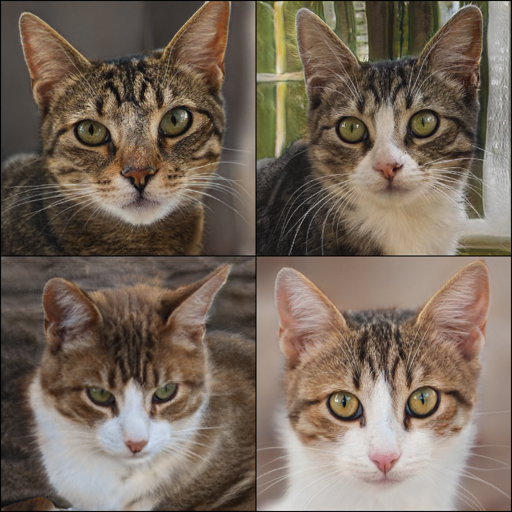

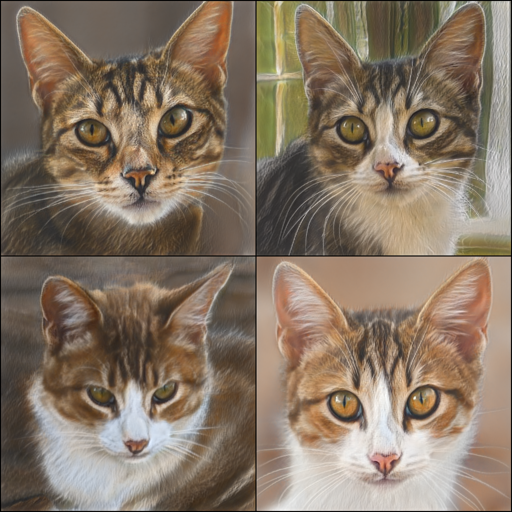

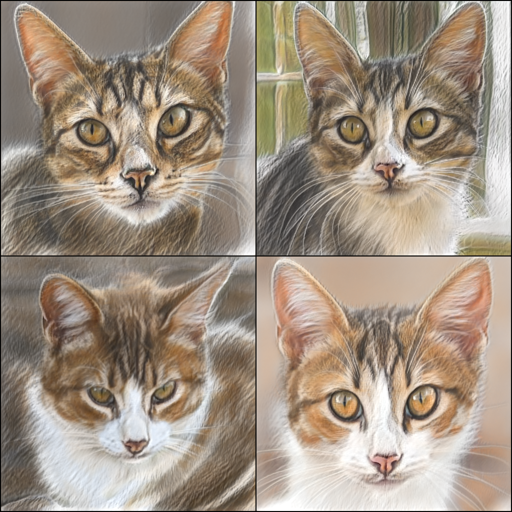

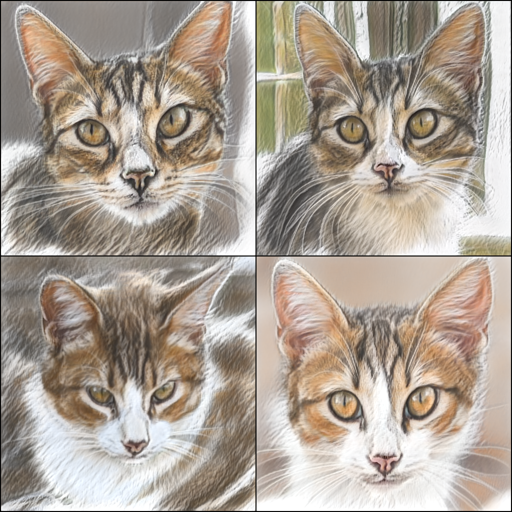

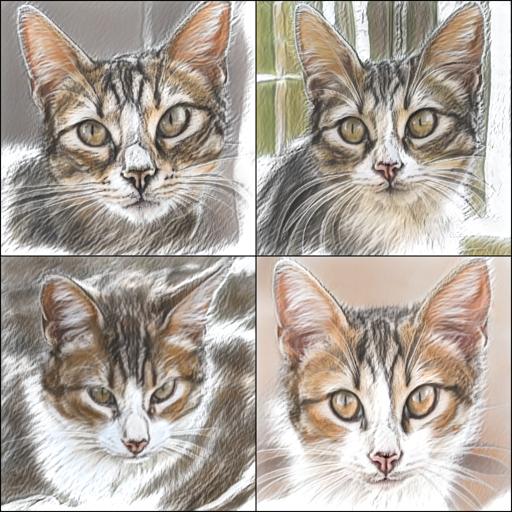

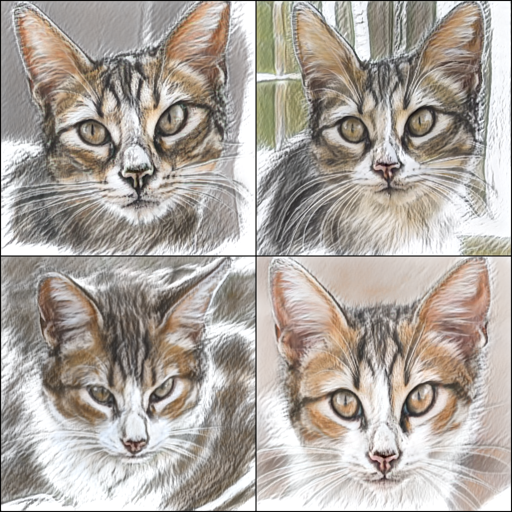

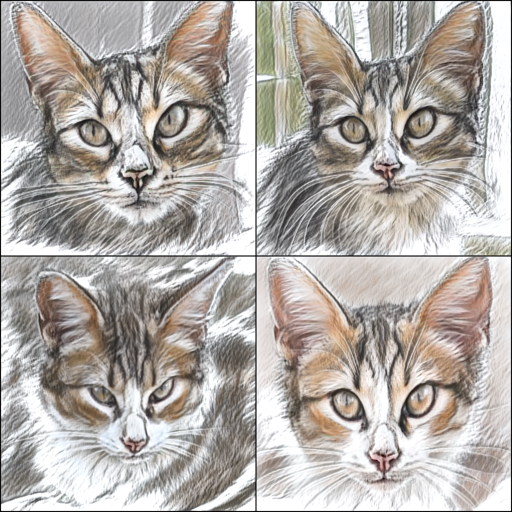

In [ ]:
from ZSSGAN.model.ZSSGAN import ZSSGAN

import numpy as np

import torch

from tqdm import notebook

from ZSSGAN.utils.file_utils import save_images

from IPython.display import display

source_class = "photo" #@param {"type": "string"}
target_class = "sketch" #@param {"type": "string"}

lambda_direction = 1.0 #@param {type:"number"}
lambda_patch = 0.0 #@param {type:"number"}
lambda_global = 0.0 #@param {type:"number"}

training_iterations = 301 #@param {type: "integer"}
output_interval     = 50 #@param {type: "integer"}

train_partial_layers = False #@param {type:"boolean"}
phase = "texture" if train_partial_layers else None

training_args = {
            "size": dataset_sizes[source_model_type],
            "batch": 2,
            "n_sample": 4,
            "output_dir": output_dir,
            "lr": 0.002,
            "frozen_gen_ckpt": os.path.join(pretrained_model_dir, pt_file_name),
            "train_gen_ckpt": os.path.join(pretrained_model_dir, pt_file_name),
            "iter": training_iterations,
            "source_class": source_class,
            "target_class": target_class,
            "lambda_direction": lambda_direction,
            "lambda_patch": lambda_patch,
            "lambda_global": lambda_global,
            "phase": phase,
            "sample_truncation": 0.7
}

args = Namespace(**training_args)

net = ZSSGAN(args)

g_reg_ratio = 4 / 5

g_optim = torch.optim.Adam(
    net.generator_trainable.parameters(),
    lr=args.lr * g_reg_ratio,
    betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio),
)

# Set up output directories.
sample_dir = os.path.join(args.output_dir, "sample")
ckpt_dir   = os.path.join(args.output_dir, "checkpoint")

os.makedirs(sample_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

seed = 3 #@param {"type": "integer"}

torch.manual_seed(seed)
np.random.seed(seed)

# Training loop
fixed_z = torch.randn(args.n_sample, 512, device=device)

for i in notebook.tqdm(range(args.iter)):

    sample_z = torch.randn(args.batch, 512, device=device)

    [sampled_src, sampled_dst], [cycle_dst, cycle_src], clip_loss, cycle_loss = net([sample_z])

    net.zero_grad()
    clip_loss.backward()

    g_optim.step()

    if i % output_interval == 0:
        with torch.no_grad():
            [sampled_src, sampled_dst], [cycle_dst, cycle_src], clip_loss, cycle_loss = net([fixed_z], truncation=args.sample_truncation)

            grid_rows = int(args.n_sample ** 0.5)

            save_images(sampled_dst, sample_dir, "dst", grid_rows, i)

            display(Image.open(os.path.join(sample_dir, f"dst_{str(i).zfill(6)}.png")).resize((512, 512)))

# Step 4: Generate samples with the new model

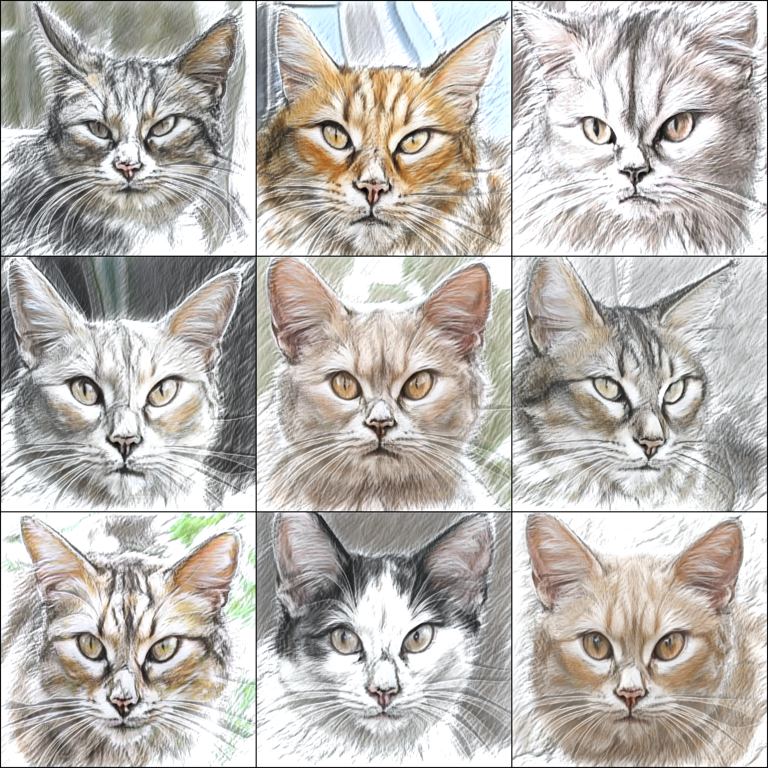

In [ ]:
truncation = 0.7 #@param {type:"slider", min:0, max:1, step:0.05}

samples = 9

with torch.no_grad():
    sample_z = torch.randn(samples, 512, device=device)

    [sampled_src, sampled_dst], [cycle_dst, cycle_src], clip_loss, cycle_loss = net([sample_z], truncation=truncation)

    grid_rows = int(samples ** 0.5)

    save_images(sampled_dst, sample_dir, "sampled", grid_rows, 0)

    display(Image.open(os.path.join(sample_dir, f"sampled_{str(0).zfill(6)}.png")).resize((768, 768)))

## Editing a real image with Re-Style inversion (currently only FFHQ inversion is supported):

Step 1: Set up the Re-Style model.

Choose the pSp model for better reconstructions. 
We found that for some extreme modifications (typically those which require 500+ training iterations), e4e may perform better.

In [ ]:
encoder_type = 'e4e' #@param['psp', 'e4e']

restyle_experiment_args = {
    "model_path": os.path.join(pretrained_model_dir, f"restyle_{encoder_type}_ffhq_encode.pt"),
    "transform": transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
}

model_path = restyle_experiment_args['model_path']
ckpt = torch.load(model_path, map_location='cpu')

opts = ckpt['opts']

opts['checkpoint_path'] = model_path
opts = Namespace(**opts)

restyle_net = (pSp if encoder_type == 'psp' else e4e)(opts)

restyle_net.eval()
restyle_net.cuda()
print('Model successfully loaded!')

Loading ReStyle e4e from checkpoint: /content/models/restyle_e4e_ffhq_encode.pt
Model successfully loaded!


Step 2: Align and invert an image

In [ ]:
def run_alignment(image_path):
    import dlib
    from scripts.align_faces_parallel import align_face
    if not os.path.exists("shape_predictor_68_face_landmarks.dat"):
        print('Downloading files for aligning face image...')
        os.system('wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2')
        os.system('bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2')
        print('Done.')
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(filepath=image_path, predictor=predictor) 
    print("Aligned image has shape: {}".format(aligned_image.size))
    return aligned_image 

image_path = "/content/bskia.jpeg  " #@param {'type': 'string'}
original_image = Image.open(image_path).convert("RGB")

input_image = run_alignment(image_path)

display(input_image)

img_transforms = restyle_experiment_args['transform']
transformed_image = img_transforms(input_image)

def get_avg_image(net):
    avg_image = net(net.latent_avg.unsqueeze(0),
                    input_code=True,
                    randomize_noise=False,
                    return_latents=False,
                    average_code=True)[0]
    avg_image = avg_image.to('cuda').float().detach()
    return avg_image

opts.n_iters_per_batch = 5
opts.resize_outputs = False  # generate outputs at full resolution

from restyle.utils.inference_utils import run_on_batch

with torch.no_grad():
    avg_image = get_avg_image(restyle_net)
    result_batch, result_latents = run_on_batch(transformed_image.unsqueeze(0).cuda(), restyle_net, opts, avg_image)

FileNotFoundError: ignored

Step 3: Convert the image to the new domain

In [ ]:
#@title Convert inverted image.
inverted_latent = torch.Tensor(result_latents[0][4]).cuda().unsqueeze(0).unsqueeze(1)

with torch.no_grad():
    [sampled_src, sampled_dst] = net(inverted_latent, input_is_latent=True)[0]
    
    joined_img = torch.cat([sampled_src, sampled_dst], dim=0)
    save_images(joined_img, sample_dir, "joined", 2, 0)
    display(Image.open(os.path.join(sample_dir, f"joined_{str(0).zfill(6)}.png")).resize((512, 256)))

NameError: ignored